## Prep/loading data

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import StandardScaler
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.back_transformations import inverse_scale_variable, predict_with_back_transform

Get regression results objects

In [97]:
%store -r bivariate_regressions
%store -r bivariate_regressions_accounts
%store -r single_regressions
%store -r single_regressions_accounts
%store -r multiple_regressions
%store -r multiple_regressions_accounts

Here's an example of what info each object has, `data` contains the data used to fit the regression in a data frame, model is the `model` object

In [98]:
bivariate_regressions[0].keys()

dict_keys(['model', 'name', 'data', 'dependent_variable', 'independent_variables', 'goodness_of_fit'])

In [99]:
foundational_df_no_transformations = pd.read_csv('output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('output/foundational_transformed_accounts.csv')

Values from StandardScaler used to transform the data. We'll need them for the back transformation.

In [100]:
# as a data frame
scaler_df = pd.read_csv('output/scaler_values.csv')
scaler_df_accounts = pd.read_csv('output/scaler_values_accounts.csv')

In [101]:
# original scaler object used to scale the values
%store -r scaler

## Comparing goodness of fit

Print our goodness of fit measures. Two rows for each type of regression since I did them with two different methods. 

The second value for each regression is likely more reliable, since I used an [existing panel analysis library](https://github.com/bashtage/linearmodels) for this one. The disadvantage is that it didn't calculate an AIC (shown as NaN), need to do this manually.

Labour cost survey data

In [121]:
all_regressions = bivariate_regressions + single_regressions + multiple_regressions
df_regressions = pd.DataFrame(all_regressions)

Which bivariate regressions have the best $R^2$?

In [120]:
bivariate_regressions_df = df_regressions[df_regressions['name'].str.contains('Bivariate')]
bivariate_regressions_df = bivariate_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_overview = bivariate_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_overview = pd.concat([bivariate_regressions_df_overview.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview = bivariate_regressions_df_overview.drop(['model_name'], axis=1)
bivariate_regressions_df_overview.head(10)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC
2,Fixed Effects Bivariate,hale,[energy],0.921961,6.503024,52.993953
8,Fixed Effects Bivariate,education,[energy],0.819813,-37.349622,140.699243
14,Fixed Effects Bivariate,socialsupport,[energy],0.725883,-45.561200,157.122399
6,Pooled OLS Bivariate,education,[energy],0.221788,-125.423934,254.847868
0,Pooled OLS Bivariate,hale,[energy],0.220083,-121.003231,246.006461
7,Pooled OLS Bivariate linearmodels,education,[energy],0.213236,-125.423934,NaN
1,Pooled OLS Bivariate linearmodels,hale,[energy],0.211513,-121.003231,NaN
12,Pooled OLS Bivariate,socialsupport,[energy],0.162765,-117.352059,238.704119
13,Pooled OLS Bivariate linearmodels,socialsupport,[energy],0.153565,-117.352059,NaN
16,Random Effects Bivariate,socialsupport,[energy],0.080253,-67.824175,139.648350


I don't entirely trust the fixed effects result, it seems to have the best r squared but this value might not be entirely comparable to other models (need to revisit how this was calculated).
Will use it for now though, for demonstration purposes.

In [131]:
# this actually doesn't pick by index from the table, but just by order they are shown above
selected_bivariate_model_hale = bivariate_regressions_df.iloc[0]['model']
selected_bivariate_model_education = bivariate_regressions_df.iloc[1]['model']
selected_bivariate_model_socialsupport = bivariate_regressions_df.iloc[2]['model']

Which single regressions have the best $R^2$?

In [140]:
single_regressions_df = df_regressions[df_regressions['name'].str.contains('Single')]
single_regressions_df = single_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_overview = single_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_overview = pd.concat([single_regressions_df_overview.drop(['goodness_of_fit'], axis=1), single_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_overview = single_regressions_df_overview.drop(['model_name'], axis=1)
single_regressions_df_overview.head(20)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC
20,Fixed Effects Single,hale,"[energy, overlooked]",0.926191,9.898590,48.202820
44,Fixed Effects Single,education,"[energy, overlooked]",0.834751,-32.505491,133.010983
68,Fixed Effects Single,socialsupport,"[energy, overlooked]",0.743649,-41.635076,151.270152
50,Fixed Effects Single,education,"[energy, material]",0.357439,-20.790302,109.580604
29,Random Effects Single linearmodels,hale,"[energy, material]",0.336594,-4.434233,NaN
24,Pooled OLS Single,hale,"[energy, material]",0.302428,-0.049945,8.099889
25,Pooled OLS Single linearmodels,hale,"[energy, material]",0.294590,-0.049945,NaN
27,Fixed Effects Single linearmodels,hale,"[energy, material]",0.278388,22.653758,NaN
42,Pooled OLS Single,education,"[energy, overlooked]",0.266257,-121.625421,251.250843
26,Fixed Effects Single,hale,"[energy, material]",0.260321,16.252212,35.495577


Pick some interesting models from the table

In [ ]:
selected_single_model_hale_material = single_regressions_df.iloc[4]['model']
selected_single_model_education_material = single_regressions_df.iloc[3]['model']
selected_single_model_socialsupport_material = single_regressions_df.iloc[14]['model']

selected_single_model_hale_providential = single_regressions_df.iloc[12]['model']
selected_single_model_education_providential = single_regressions_df.iloc[15]['model']

selected_single_model_hale_overlooked = single_regressions_df.iloc[0]['model']
selected_single_model_education_overlooked = single_regressions_df.iloc[1]['model']
selected_single_model_socialsupport_overlooked = single_regressions_df.iloc[2]['model']

Which multiple regressions have the best $R^2$?

In [118]:
multiple_regressions_df = df_regressions[df_regressions['name'].str.contains('Multiple')]
multiple_regressions_df = multiple_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
multiple_regressions_df_overview = multiple_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
multiple_regressions_df_overview = pd.concat([multiple_regressions_df_overview.drop(['goodness_of_fit'], axis=1), multiple_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
multiple_regressions_df_overview = multiple_regressions_df_overview.drop(['model_name'], axis=1)
multiple_regressions_df_overview.head(30)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC
134,Fixed Effects Multiple,hale,"[energy, other, gini]",0.940245,19.284830,27.430340
128,Fixed Effects Multiple,hale,"[energy, other, goveffectiveness]",0.937106,18.210386,33.579228
110,Fixed Effects Multiple,hale,"[energy, material, gini]",0.936345,16.723793,32.552414
98,Fixed Effects Multiple,hale,"[energy, overlooked, gini]",0.936171,16.613442,32.773117
104,Fixed Effects Multiple,hale,"[energy, material, goveffectiveness]",0.934130,16.037334,37.925333
122,Fixed Effects Multiple,hale,"[energy, providential, gini]",0.933285,14.822475,36.355049
92,Fixed Effects Multiple,hale,"[energy, overlooked, goveffectiveness]",0.927876,11.774414,46.451172
116,Fixed Effects Multiple,hale,"[energy, providential, goveffectiveness]",0.926114,10.640057,48.719885
152,Fixed Effects Multiple,education,"[energy, material, goveffectiveness]",0.853594,-26.025033,122.050066
158,Fixed Effects Multiple,education,"[energy, material, gini]",0.853083,-20.997867,107.995733


Accounts data

In [105]:
all_regressions_accounts = bivariate_regressions_accounts + single_regressions_accounts + multiple_regressions_accounts
df_regressions_accounts = pd.DataFrame(all_regressions_accounts)
goodness_of_fit_df_accounts = pd.json_normalize(df_regressions_accounts['goodness_of_fit'])
display(goodness_of_fit_df_accounts)

,model_name,adj_r_squared,log_likelihood,AIC
0,Pooled OLS Bivariate,0.216735,-427.078845,858.157690
1,NaN,NaN,NaN,NaN
2,Fixed Effects Bivariate,0.883173,-87.151590,230.303180
3,Fixed Effects Bivariate,0.114901,-15.042643,NaN
4,Random Effects Bivariate,0.010995,-60.451619,124.903239
...,...,...,...,...
661,Pooled OLS Multiple,0.058931,-220.089666,NaN
662,Fixed Effects Multiple,0.036508,-211.206244,482.412488
663,Fixed Effects Multiple,0.094508,-211.111475,NaN
664,Random Effects Multiple,0.061971,-220.035860,450.071721


Print the best r-squared and log-likelihood models.

Some rules for model selection:
1. Will not used Pooled OLS even if it has a better R-squared (which it does in some cases), since it's not a good fit for our data. Kind of confirmed this formally with an F-test, need to finalise.
2. The first "Fixed Effects Multiple" r-squared estimates are likely exaggerated/biased, hence will rely on the second fixed effects estimate in each case.

Check coefficients for the models that have a better R-squared.

In [106]:
bivariate_regressions[5]['model'].summary

Dep. Variable:,hale,R-squared:,0.0421
Estimator:,RandomEffects,R-squared (Between):,0.2051
No. Observations:,94,R-squared (Within):,-0.0684
Date:,"Thu, Feb 08 2024",R-squared (Overall):,0.0434
Time:,22:23:31,Log-likelihood,-17.459
Cov. Estimator:,Unadjusted,,
,,F-statistic:,4.0467
Entities:,33,P-value,0.0472
Avg Obs:,2.8485,Distribution:,"F(1,92)"
Min Obs:,1.0000,,
Max Obs:,3.0000,F-statistic (robust):,4.0466


In [107]:
single_regressions[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hale   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     8.884
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           3.22e-05
Time:                        22:25:19   Log-Likelihood:                -121.00
No. Observations:                  94   AIC:                             250.0
Df Residuals:                      90   BIC:                             260.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0772      0.102     -0.755      0.452      -0.280       0.126
energy               -0.5179      0.121     -4.293      0.000      -0.758      -0.278
overlooked           -0.0006      0.137     -0.005      0.996      -0.272       0.271
energy:overlooked    -0.0002      0.111     -0.002      0.998      -0.221       0.221
==============================================================================
Omnibus:                        2.620   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                1.999
Skew:                          -0.197   Prob(JB):                        0.368
Kurtosis:                       2.404   Cond. No.                         2.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot without back transformation

In [108]:
single_reg_data = single_regressions[0]['data']
temp_merged_df = foundational_df_no_transformations.merge(single_reg_data[['geo', 'TIME_PERIOD']], on=['geo', 'TIME_PERIOD'], how='inner')
foundational_df_no_transformations_no_outliers = temp_merged_df[foundational_df_no_transformations.columns]

Try and plot back transformed values for the single regression

In [109]:
non_transformed_data = foundational_df_no_transformations
transformed_data = foundational_df_transformed

inversed_data_energy = inverse_scale_variable(transformed_data['energy'], 'energy', scaler_df)
inversed_data_material = inverse_scale_variable(transformed_data['material'], 'material', scaler_df)
inversed_data_providential = inverse_scale_variable(transformed_data['providential'], 'providential', scaler_df)
inversed_data_overlooked = inverse_scale_variable(transformed_data['overlooked'], 'overlooked', scaler_df)
inversed_data_other = inverse_scale_variable(transformed_data['other'], 'other', scaler_df)
inversed_data_hale = inverse_scale_variable(transformed_data['hale'], 'hale', scaler_df)
inversed_data_education = inverse_scale_variable(transformed_data['education'], 'education', scaler_df)
inversed_data_social_support = inverse_scale_variable(transformed_data['socialsupport'], 'socialsupport', scaler_df)

back_transformed_data = pd.DataFrame()
back_transformed_data['energy'] = np.exp(inversed_data_energy)
back_transformed_data['material'] = np.exp(inversed_data_material)
back_transformed_data['providential'] = np.exp(inversed_data_providential)
back_transformed_data['overlooked'] = np.exp(inversed_data_overlooked)
back_transformed_data['other'] = np.exp(inversed_data_other)
back_transformed_data['hale'] = 1.1 * 72.7 - np.exp(inversed_data_hale)
back_transformed_data['education'] = 1.1 * 0.985 - np.exp(inversed_data_education)
back_transformed_data['socialsupport'] = 1.1 * 19.69990921 - np.exp(inversed_data_social_support)


back_transformed_data_with_geo = back_transformed_data.copy()
back_transformed_data_with_geo[['geo', 'TIME_PERIOD']] = transformed_data[['geo', 'TIME_PERIOD']]

In [110]:
bivariate_predictions = predict_with_back_transform(
    bivariate_regressions[5]["model"],
    'hale',
    ['energy'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
)
single_predictions_material_mean = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
)
single_predictions_material_low = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "LOW",
)
single_predictions_material_high = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "HIGH",
)

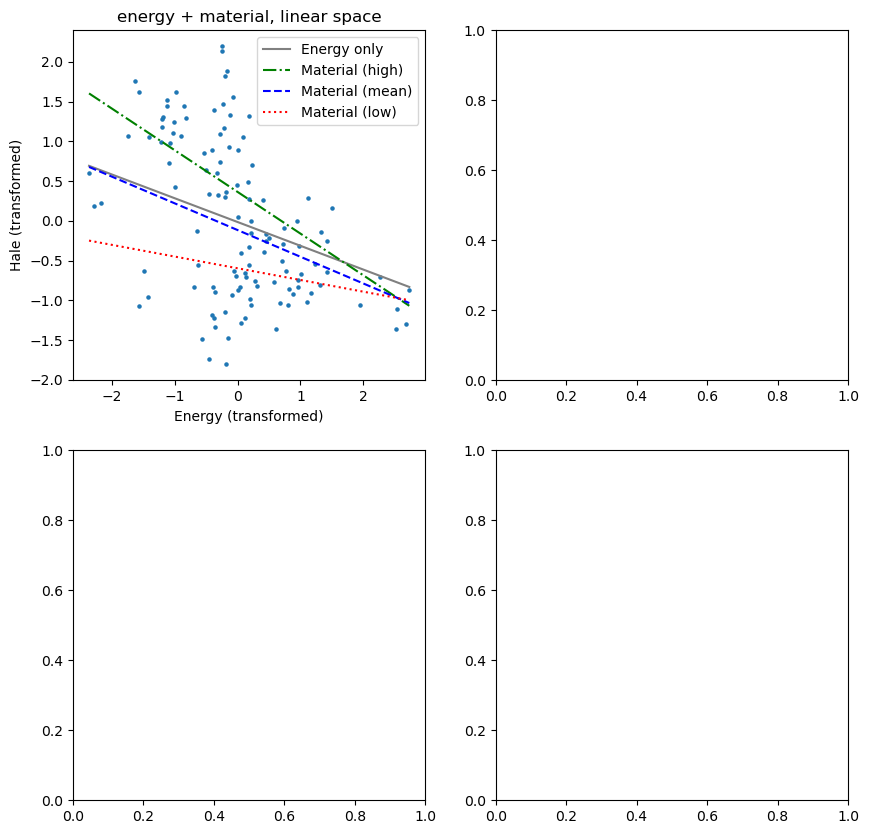

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(transformed_data["energy"], transformed_data["hale"], s=5)
axs[0, 0].set_title('energy + material, linear space')
axs[0, 0].set_xlabel('Energy (transformed)')
axs[0, 0].set_ylabel('Hale (transformed)')

# plot the predicted values
axs[0, 0].plot(bivariate_predictions["energy_transformed"], bivariate_predictions["predicted_hale"], color='gray', label='Energy only')
axs[0, 0].plot(single_predictions_high["energy_transformed"], single_predictions_high["predicted_hale"], color='green', linestyle='-.', label='Material (high)')
axs[0, 0].plot(single_predictions_mean["energy_transformed"], single_predictions_mean["predicted_hale"], color='blue', linestyle='--', label='Material (mean)')
axs[0, 0].plot(single_predictions_low["energy_transformed"], single_predictions_low["predicted_hale"], color='red', linestyle=':', label='Material (low)')
axs[0, 0].legend()

In [112]:
bivariate_predictions_back_transformed = predict_with_back_transform(
    bivariate_regressions[5]["model"],
    'hale',
    ['energy'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    back_transform_y=True
)
single_predictions_back_transformed_mean = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    back_transform_y=True
)
single_predictions_back_transformed_low = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "LOW",
    back_transform_y=True
)
single_predictions_back_transformed_high = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "HIGH",
    back_transform_y=True
)

In [113]:
def log_tick_formatter(val, pos=None):
    return "{:.0f}".format(10**val)

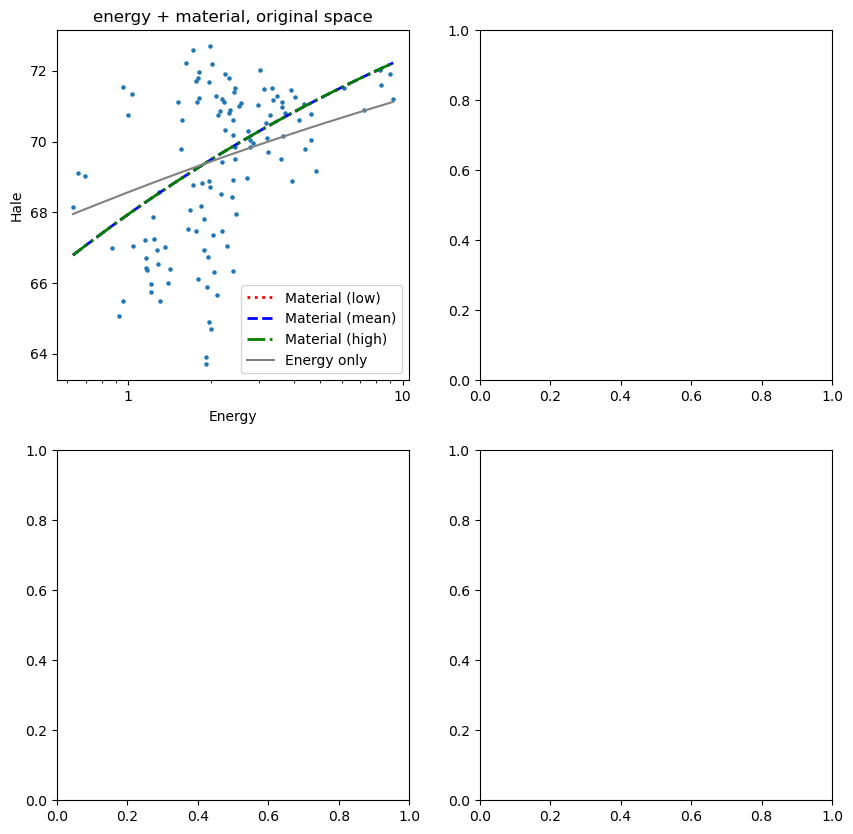

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(back_transformed_data["energy"], back_transformed_data["hale"], s=5)
axs[0, 0].set_title('energy + material, original space')
# log x axis
axs[0, 0].set_xscale('log')
axs[0, 0].xaxis.set_major_locator(LogLocator(base=10.0))
axs[0, 0].xaxis.set_major_formatter(FuncFormatter(lambda val, pos: "{:.0f}".format(val)))
axs[0, 0].set_xlabel('Energy')
axs[0, 0].set_ylabel('Hale')

# plot the predicted values
axs[0, 0].plot(single_predictions_back_transformed_low["energy"], single_predictions_back_transformed_low["predicted_hale"], color='red', linestyle=':', linewidth=2, label='Material (low)')
axs[0, 0].plot(single_predictions_back_transformed_mean["energy"], single_predictions_back_transformed_mean["predicted_hale"], color='blue', linestyle='--', linewidth=2, label='Material (mean)')
axs[0, 0].plot(single_predictions_back_transformed_high["energy"], single_predictions_back_transformed_high["predicted_hale"], color='green', linestyle='-.', linewidth=2, label='Material (high)')
axs[0, 0].plot(bivariate_predictions_back_transformed["energy"], bivariate_predictions_back_transformed["predicted_hale"], color='gray', label='Energy only')
axs[0, 0].legend()
# axs[0, 1].scatter(back_transformed_single_reg_data["energy"], back_transformed_single_reg_data["education"])
# axs[0, 1].set_title('education vs energy back-transformed')
# axs[1, 0].scatter(back_transformed_single_reg_data["energy"], back_transformed_single_reg_data["socialsupport"])
# axs[1, 0].set_title('socialsupport vs energy back-transformed')
# axs[1, 1].scatter(back_transformed_single_reg_data["energy"], back_transformed_single_reg_data["schoolenr"])
# axs[1, 1].set_title('schoolenr vs energy back-transformed')